# IS5152 Project
## Beijing PM2.5 prediction

In [11]:
import os

# data manipulation
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

# visualiation
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from utils import read_data, prediction_accuracy

# Import Prophet
from fbprophet import Prophet

## Seasonality Analysis

Loaded  data\PRSA_Data_Aotizhongxin_20130301-20170228.csv
Loaded  data\PRSA_Data_Changping_20130301-20170228.csv
Loaded  data\PRSA_Data_Dingling_20130301-20170228.csv
Loaded  data\PRSA_Data_Dongsi_20130301-20170228.csv
Loaded  data\PRSA_Data_Guanyuan_20130301-20170228.csv
Loaded  data\PRSA_Data_Gucheng_20130301-20170228.csv
Loaded  data\PRSA_Data_Huairou_20130301-20170228.csv
Loaded  data\PRSA_Data_Nongzhanguan_20130301-20170228.csv
Loaded  data\PRSA_Data_Shunyi_20130301-20170228.csv
Loaded  data\PRSA_Data_Tiantan_20130301-20170228.csv
Loaded  data\PRSA_Data_Wanliu_20130301-20170228.csv
Loaded  data\PRSA_Data_Wanshouxigong_20130301-20170228.csv


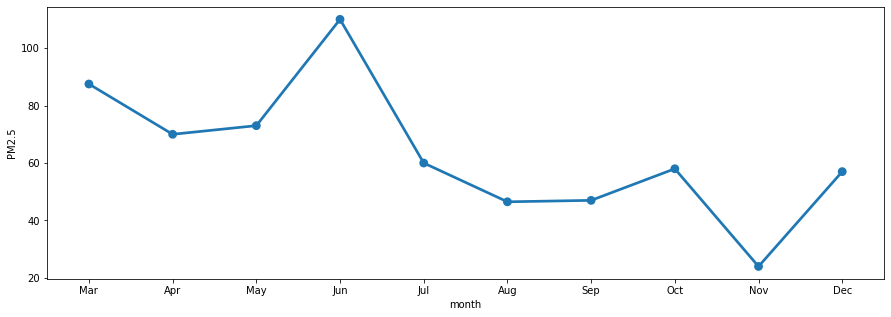

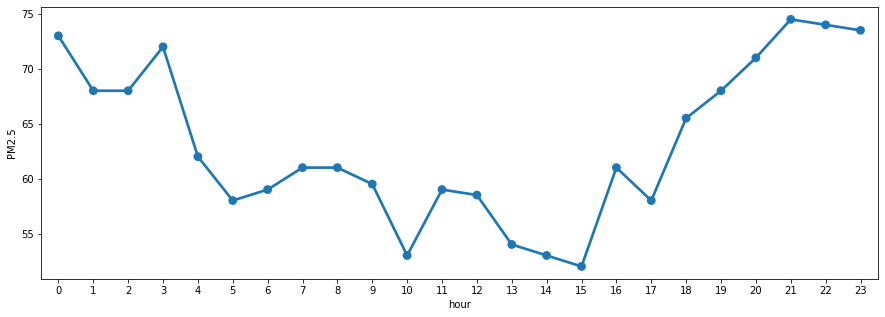

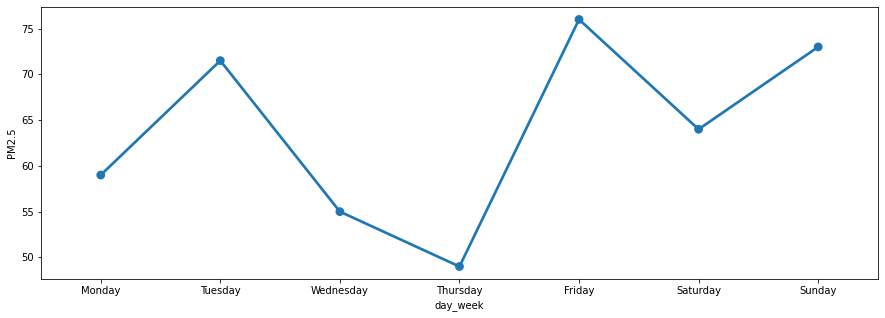

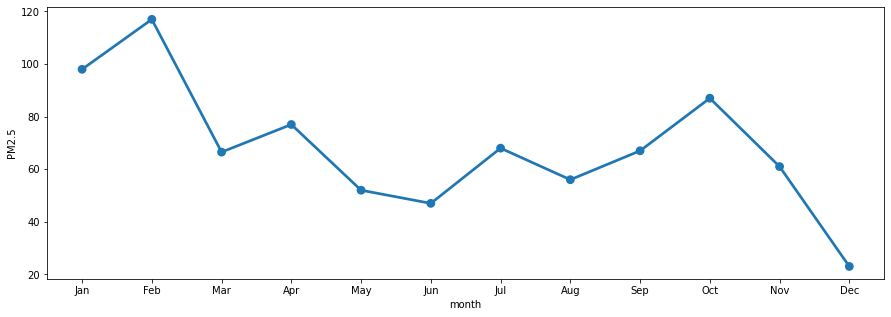

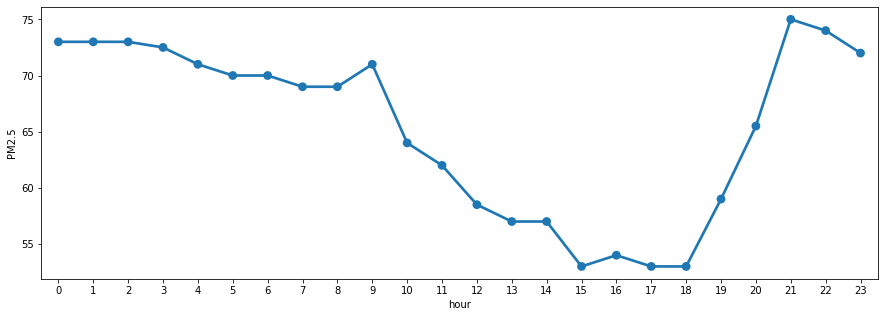

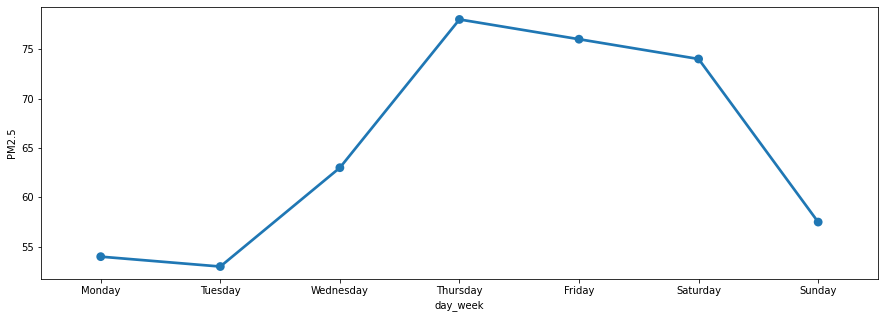

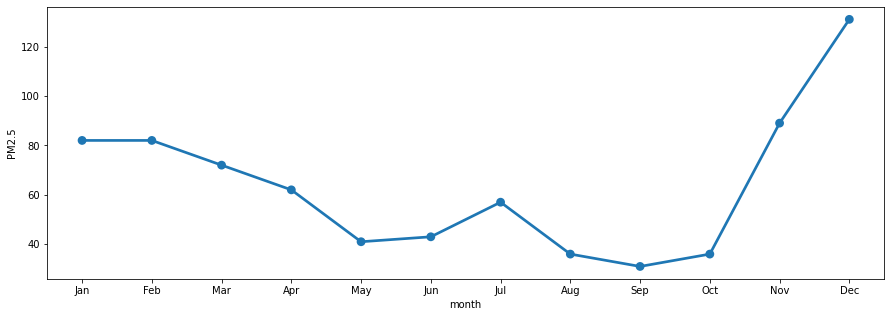

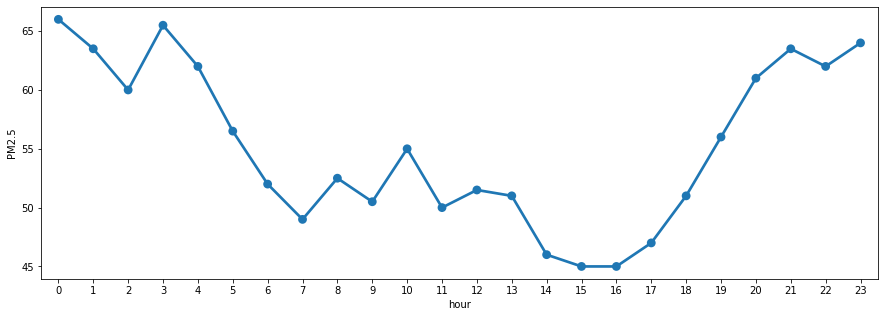

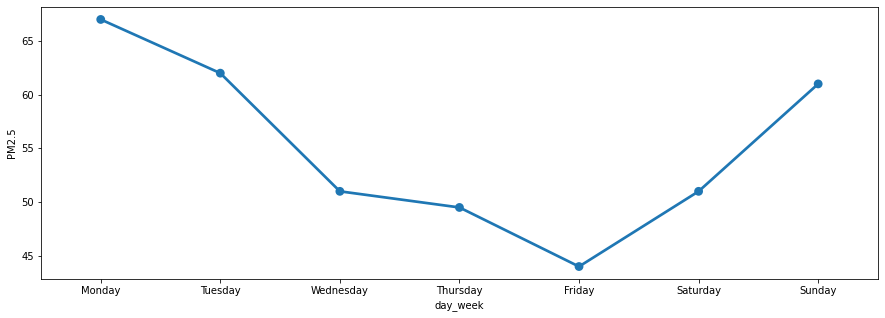

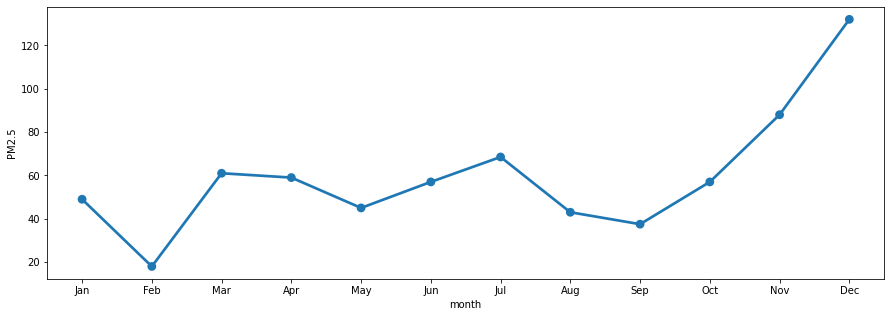

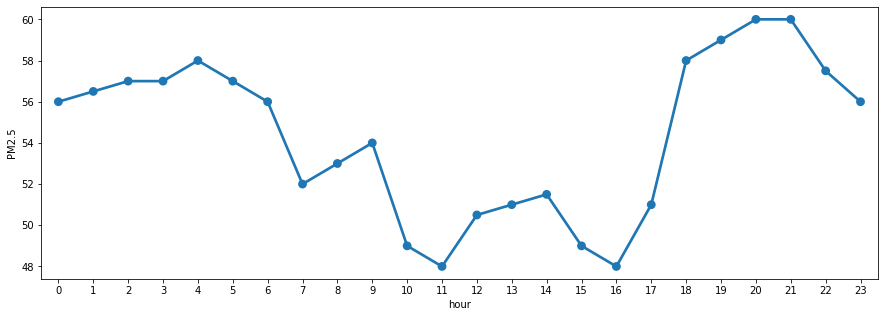

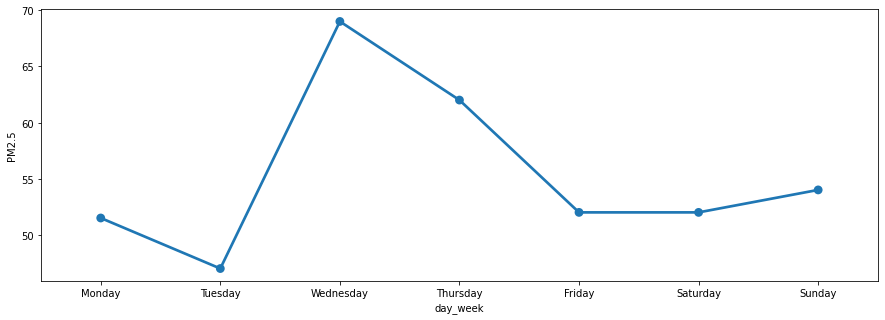

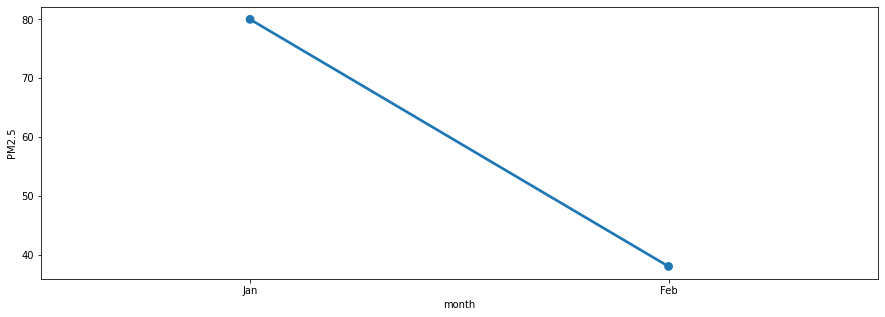

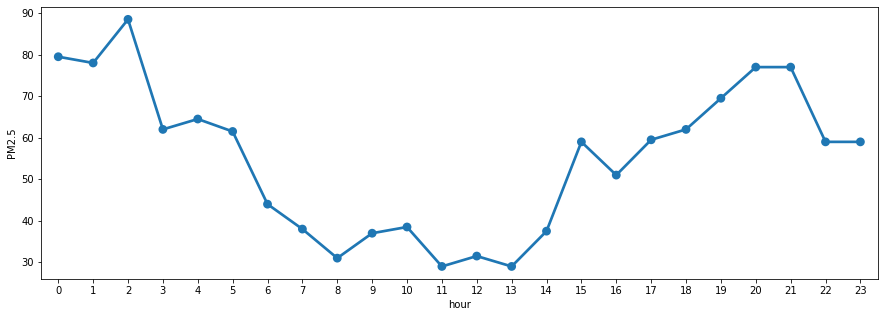

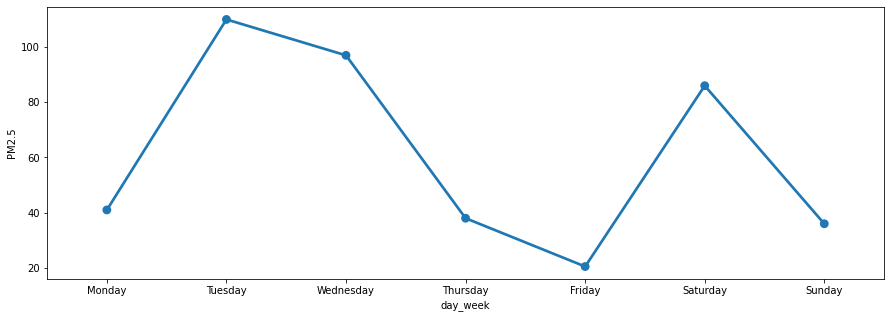

In [45]:
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print('Loaded ',os.path.join(dirname, filename))
        frame = pd.read_csv(os.path.join(dirname, filename))

import calendar
# function to find day of the week based on the date field
def findDay(date): 
    dayname = calendar.day_name[date.weekday()]
    return dayname

# creating date field for further analysis by extracting day of the week, month etc.
frame['date']=pd.to_datetime(frame[['year', 'month', 'day']])
frame['day_week'] = frame['date'].apply(lambda x: findDay(x))
custom_day = {'Monday':0, 'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6}

frame.month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], inplace=True)
custom_dict = {'Jan':0, 'Feb':1,'Mar':2,'Apr':3,'May':4,'Jun':5,'Jul':6,'Aug':7,'Sep':8,'Oct':9,'Nov':10,'Dec':11} 

years = [2013, 2014, 2015, 2016, 2017]
for year in years:
    df = frame[frame['year']==year].copy()
    df = df.dropna()
    df1 = df[['PM2.5','month']].groupby(["month"]).median().reset_index().sort_values(by='month',ascending=True)
    df1 = df1.iloc[df1['month'].map(custom_dict).argsort()]
    f,ax=plt.subplots(figsize=(15,5))
    fig1 = sb.pointplot(x='month', y='PM2.5', data=df1)
    
    df2 = df[['PM2.5','hour']].groupby(["hour"]).median().reset_index().sort_values(by='hour',ascending=False)
    f,ax=plt.subplots(figsize=(15,5))
    fig2 = sb.pointplot(x='hour', y='PM2.5', data=df2)
    
    df3 = df[['PM2.5','day_week']].groupby(["day_week"]).median().reset_index().sort_values(by='day_week',ascending=True)
    df3 = df3.iloc[df3['day_week'].map(custom_day).argsort()]
    f,ax=plt.subplots(figsize=(15,5))
    fig3 = sb.pointplot(x='day_week', y='PM2.5', data=df3)

### Use one location data

In [14]:
# train one location data
train_df = dataset.train_val_df.copy()
train_df1 = train_df[train_df['station'] == 'Aotizhongxin']
test_df = dataset.test_df.copy()
test_df1 = test_df[test_df['station'] == 'Aotizhongxin']
train_df1 = train_df1[['PM2.5','time_stamp','station']].groupby(["time_stamp"]).median().reset_index().sort_values(by='time_stamp',ascending=True)
test_df1 = test_df1[['time_stamp','PM2.5']].sort_values(by='time_stamp',ascending=True).reset_index(drop=True)

In [16]:
train_df1.describe()

,y
count,26900.000000
mean,80.840498
std,77.639467
min,3.000000
25%,23.000000
50%,58.000000
75%,112.000000
max,713.000000


train: 26900, test: 4915
Forcast Data is: 
                    ds       yhat  yhat_lower  yhat_upper
0 2016-07-24 21:00:00  65.056518  -33.856217  160.979040
1 2016-07-24 22:00:00  66.916929  -28.781389  160.935612
2 2016-07-24 23:00:00  67.535344  -30.846736  165.119831
3 2016-07-25 00:00:00  67.221240  -32.669695  167.132883
4 2016-07-25 01:00:00  66.187879  -25.404614  163.971353
Comparison between actual and forecast: 
                           yhat  yhat_lower  yhat_upper     y
ds                                                          
2016-07-24 21:00:00  65.056518  -33.856217  160.979040  73.0
2016-07-24 22:00:00  66.916929  -28.781389  160.935612  82.0
2016-07-24 23:00:00  67.535344  -30.846736  165.119831  73.0
2016-07-25 00:00:00  67.221240  -32.669695  167.132883  55.0
2016-07-25 01:00:00  66.187879  -25.404614  163.971353  65.0
2016-07-25 02:00:00  64.376892  -26.920124  164.944037  51.0
2016-07-25 03:00:00  61.720837  -37.525500  148.470599  51.0
2016-07-25 04:00:00  58

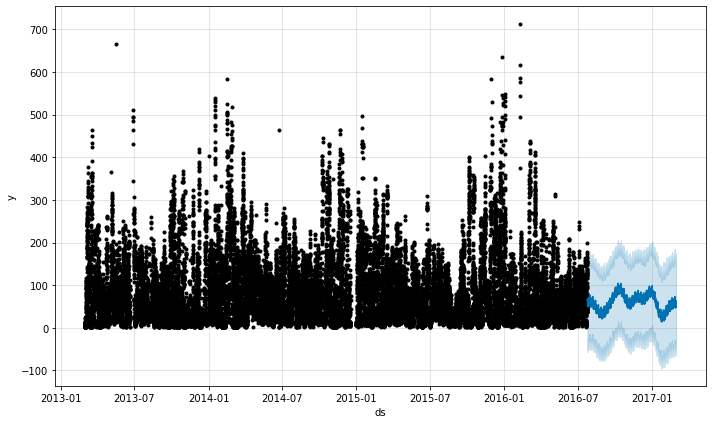

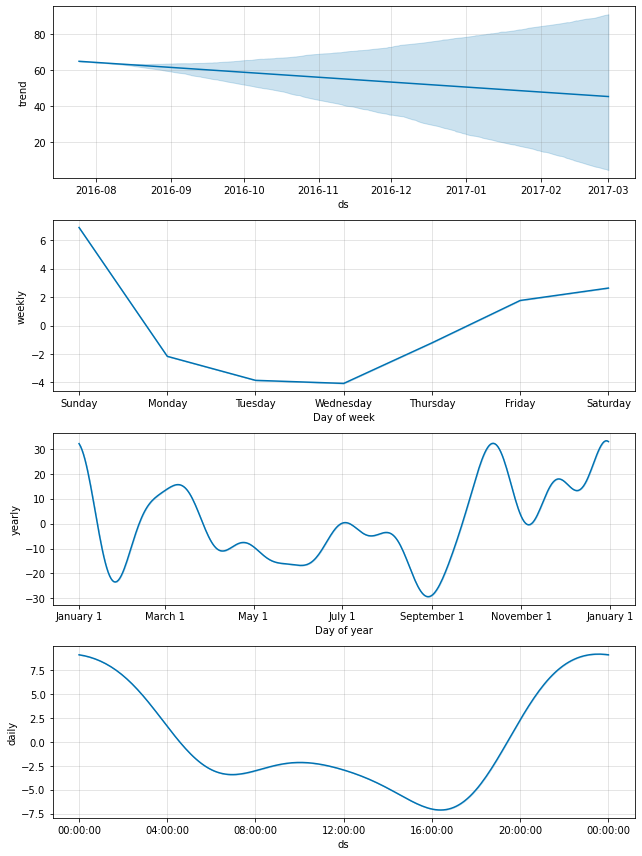

In [15]:
# Change the column names according to Prophet's guidelines
train_df1.columns = ['ds', 'y']
test_df1.columns = ['ds', 'y']

# Split into a train/test set
print("train: %d, test: %d" % (len(train_df1),len(test_df1)))

# Initialize and train a model
m = Prophet(daily_seasonality=True)
m.fit(train_df1)

# Make predictions
forecast = m.predict(test_df1)
print("Forcast Data is: \n", forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# Plot forecast
fig1 = m.plot(forecast)

# Plot forecast's components
fig2 = m.plot_components(forecast)

cmp_df = make_comparison_dataframe(test_df1, forecast)
print("Comparison between actual and forecast: \n", cmp_df)

for err_name, err_value in calculate_forecast_errors(cmp_df).items():
    print(err_name, err_value)

# Time Series:

In [ ]:
# Load all data
dataset = read_data(normalize = False)
print(dataset.train_val_df.describe())
print(dataset.test_df.describe())
print(dataset.all_df.describe())

In [3]:
dataset.train_val_df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,station,time_stamp,WD_E,WD_ENE,WD_ESE,WD_N,WD_NE,WD_NNE,WD_NNW,WD_NW,WD_S,WD_SE,WD_SSE,WD_SSW,WD_SW,WD_W,WD_WNW,WD_WSW
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,Aotizhongxin,2013-03-01 00:00:00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,Aotizhongxin,2013-03-01 01:00:00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,Aotizhongxin,2013-03-01 02:00:00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1,Aotizhongxin,2013-03-01 03:00:00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0,Aotizhongxin,2013-03-01 04:00:00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
train_df = dataset.train_val_df.copy()
test_df = dataset.test_df.copy()
train_df = train_df[['PM2.5','time_stamp','station']].groupby(["time_stamp"]).median().reset_index().sort_values(by='time_stamp',ascending=True)
test_df = test_df[['time_stamp','PM2.5']].sort_values(by='time_stamp',ascending=True).reset_index(drop=True)
print(train_df.head())
print(train_df['time_stamp'].describe())
print(test_df.head())
print(test_df['time_stamp'].describe())
#plt.subplots(figsize=(15,5))
#sb.pointplot(x='time_stamp', y='PM2.5', data=time_df)

           time_stamp  PM2.5
0 2013-03-01 00:00:00    5.5
1 2013-03-01 01:00:00    8.0
2 2013-03-01 02:00:00    4.0
3 2013-03-01 03:00:00    5.0
4 2013-03-01 04:00:00    3.0
count                   29606
unique                  29606
top       2015-09-21 23:00:00
freq                        1
first     2013-03-01 00:00:00
last      2016-07-24 20:00:00
Name: time_stamp, dtype: object
           time_stamp  PM2.5
0 2016-07-24 21:00:00   73.0
1 2016-07-24 21:00:00   50.0
2 2016-07-24 21:00:00   82.0
3 2016-07-24 21:00:00   83.0
4 2016-07-24 21:00:00   49.0
count                   58550
unique                   5214
top       2016-11-27 20:00:00
freq                       12
first     2016-07-24 21:00:00
last      2017-02-28 23:00:00
Name: time_stamp, dtype: object


In [5]:
# Import Prophet
import pandas as pd
from fbprophet import Prophet

# Change the column names according to Prophet's guidelines
train_df.columns = ['ds', 'y']
test_df.columns = ['ds', 'y']

# Split into a train/test set
print("train: %d, test: %d" % (len(train_df),len(test_df)))

# Initialize and train a model
m = Prophet(daily_seasonality=True)
m.fit(train_df)

# Make predictions
forecast = m.predict(test_df)
print("Forcast Data is: \n", forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

Importing plotly failed. Interactive plots will not work.


train: 29606, test: 58550
Forcast Data is: 
                        ds       yhat  yhat_lower  yhat_upper
58545 2017-02-28 23:00:00  51.804954  -55.473742  169.020089
58546 2017-02-28 23:00:00  51.804954  -66.320084  156.727295
58547 2017-02-28 23:00:00  51.804954  -62.021467  173.403935
58548 2017-02-28 23:00:00  51.804954  -64.297796  173.180775
58549 2017-02-28 23:00:00  51.804954  -64.931190  177.381650


In [6]:
print("Forcast Data is: \n", forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

Forcast Data is: 
                        ds       yhat  yhat_lower  yhat_upper
58545 2017-02-28 23:00:00  51.804954  -55.473742  169.020089
58546 2017-02-28 23:00:00  51.804954  -66.320084  156.727295
58547 2017-02-28 23:00:00  51.804954  -62.021467  173.403935
58548 2017-02-28 23:00:00  51.804954  -64.297796  173.180775
58549 2017-02-28 23:00:00  51.804954  -64.931190  177.381650


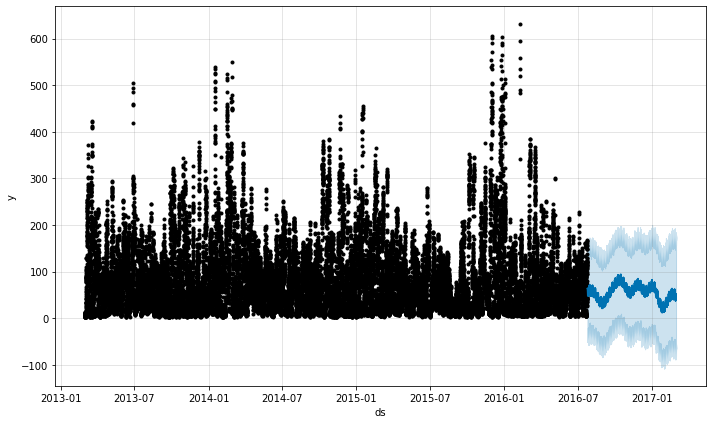

In [7]:
# Plot forecast
fig1 = m.plot(forecast)

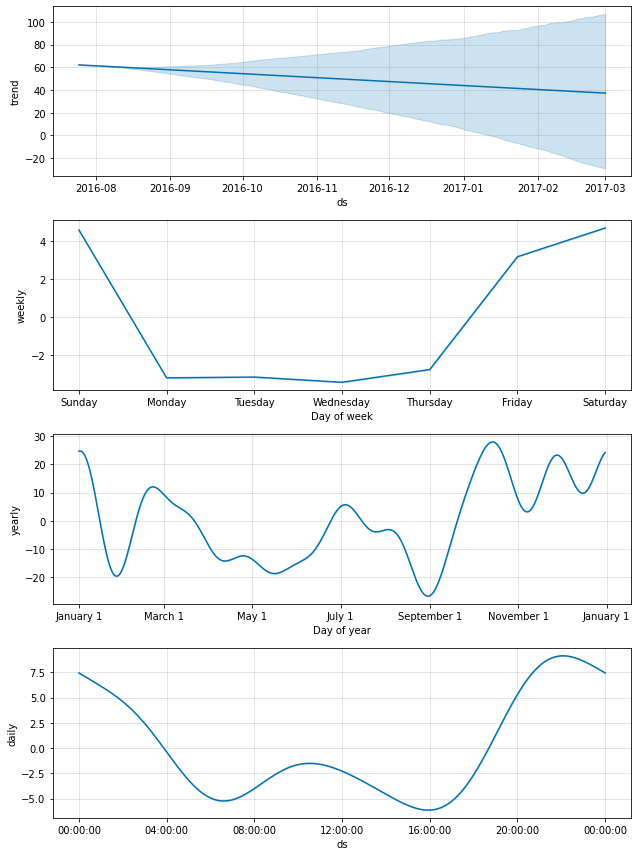

In [8]:
# Plot forecast's components
fig2 = m.plot_components(forecast)

Comparison between actual and forecast: 
                           yhat  yhat_lower  yhat_upper      y
ds                                                           
2016-07-24 21:00:00  64.063700  -28.383046  159.397073   73.0
2016-07-24 21:00:00  64.063700  -28.383046  159.397073   50.0
2016-07-24 21:00:00  64.063700  -28.383046  159.397073   82.0
2016-07-24 21:00:00  64.063700  -28.383046  159.397073   83.0
2016-07-24 21:00:00  64.063700  -28.383046  159.397073   49.0
2016-07-24 21:00:00  64.063700  -28.383046  159.397073   41.0
2016-07-24 21:00:00  64.063700  -28.383046  159.397073   60.0
2016-07-24 21:00:00  64.063700  -28.383046  159.397073  132.0
2016-07-24 21:00:00  64.063700  -28.383046  159.397073   64.0
2016-07-24 21:00:00  64.063700  -28.383046  159.397073   45.0
2016-07-24 21:00:00  64.063700  -32.623862  156.826317   73.0
2016-07-24 21:00:00  64.063700  -32.623862  156.826317   50.0
2016-07-24 21:00:00  64.063700  -32.623862  156.826317   82.0
2016-07-24 21:00:00  64.0637

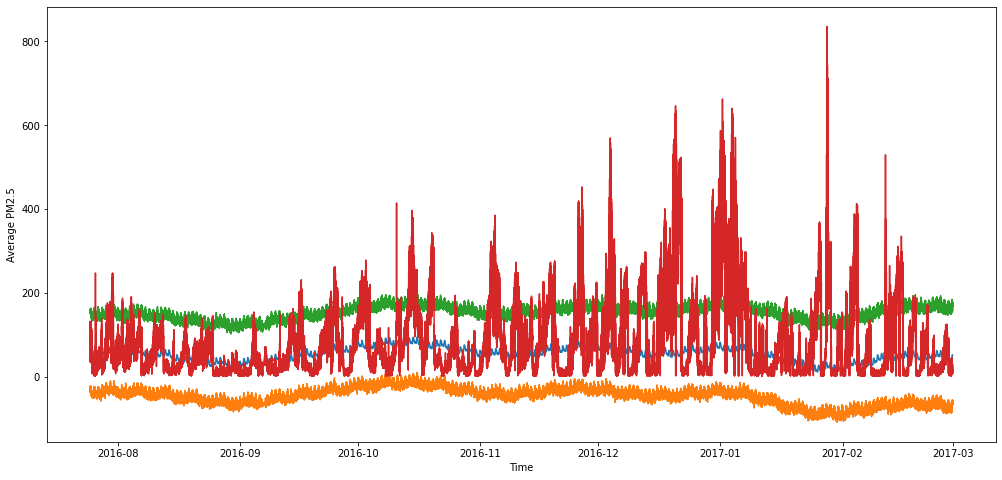

In [9]:
# Evaluate the model by mean absolute percentage error (MAPE) and mean absolute error (MAE)
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

cmp_df = make_comparison_dataframe(test_df, forecast)
print("Comparison between actual and forecast: \n", cmp_df)

def calculate_forecast_errors(df):
    
    df = df.copy()
    
    df['e'] = df['y'] - df['yhat']
    mae = abs(df['e']).mean()
    rmse = np.sqrt((df['e'] ** 2).mean())
    mse = (df['e'] ** 2).mean()
    
    return {'MAE': mae, 'RMSE': rmse, 'MSE': mse}

for err_name, err_value in calculate_forecast_errors(cmp_df).items():
    print(err_name, err_value)

# Plot forecast with upper and lower bounds
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])
plt.xlabel('Time')
plt.ylabel('Average PM2.5')
plt.grid(False)
plt.show()

In [10]:
accuracy10 = prediction_accuracy(forecast['yhat'], test_df['y'], 10)
accuracy20 = prediction_accuracy(forecast['yhat'], test_df['y'], 20)
accuracy50 = prediction_accuracy(forecast['yhat'], test_df['y'], 50)
accuracy100 = prediction_accuracy(forecast['yhat'], test_df['y'], 100)
print(accuracy10, accuracy20, accuracy50, accuracy100)

0.11742100768573868 0.24245943637916312 0.637796754910333 0.834466268146883
